# Viscoelasticity Example
Author(s): Paul Miles | Date: July 13, 2018

#### Return to [Index](https://nbviewer.jupyter.org/github/prmiles/notebooks/blob/master/pymcmcstat/index.ipynb)

In this example we highlight the use of `pymcmcstat` in the analysis of linear viscoelasticity in the dielectric elastomer Very High Bond (VHB) 4910, made by 3M.  Dielectric elastomers are known for their large-field induced deformation and broad applications in smart structures, but the rate-dependent viscoelastic effects are not well understood. To address this issue, we quantify both the hyperelastic and viscoelastic constitutive behavior and use Bayesian uncertainty analysis to assess several key modeling attributes. Specifically, we couple a nonaffine hyperelastic model with linear viscoelasticity.  For me details about the motivation behind this research as well as other aspect of the model development, please see the following publications:

- Miles, Paul, Michael Hays, Ralph Smith, and William Oates. "Bayesian uncertainty analysis of finite deformation viscoelasticity." Mechanics of Materials 91 (2015): 35-49.

- Mashayekhi, Somayeh, Paul Miles, M. Yousuff Hussaini, and William S. Oates. "Fractional viscoelasticity in fractal and non-fractal media: Theory, experimental validation, and uncertainty analysis." Journal of the Mechanics and Physics of Solids 111 (2018): 134-156.

- Solheim, Hannah, Eugenia Stanisauskis, Paul Miles, and William Oates. "Fractional viscoelasticity of soft elastomers and auxetic foams." In Behavior and Mechanics of Multifunctional Materials and Composites XII, vol. 10596, p. 1059604. International Society for Optics and Photonics, 2018.

## Basic Modeling Framework
The experimental data provides information on the materials deformation and total stress response.  The viscoelastic nature of this material leads to significant hysteresis gaps during the loading and unloading cycles.  To model this behavior we consider two different physical components: a reversible hyperelastic model as well as a linear viscoelastic model.
### Nonaffine Hyperelastic Model
The basic form of the hyperelastic stress is
$$s_{\infty} = \frac{1}{3}G_c\lambda\Big(\frac{9\lambda_{max} - I_1}{3\lambda_{max} - I_1}\Big) + G_e\lambda^{-1/2}(1-\lambda) - \frac{p}{\lambda}$$
where $\lambda$ is the stretch, $I_1$ is the first stretch invariant, $p$ is the hydrostatic pressure term (enforces incompressibility), and $G_c, G_e$ and $\lambda_{max}$ are model parameters.  For details regarding the Nonaffine energy function, see

- Davidson, Jacob D., and N. C. Goulbourne. "A nonaffine network model for elastomers undergoing finite deformations." Journal of the Mechanics and Physics of Solids 61, no. 8 (2013): 1784-1797.

In [1]:
# Define hyperelastic model
def nonaffine_hyperelastic_model(theta, stretch):
    # unpack model parameters
    Gc = theta['Gc']
    Ge = theta['Ge']
    lam_max = theta['lam_max']
    
    # Stretch Invariant
    I1 = stretch**2 + 2/stretch;
    
    # Hydrostratic pressure
    p = (Gc/3/stretch*((9*lam_max**2 - I1)/(3*lam_max**2 - I1))) + Ge/stretch**0.5*(1 - stretch);
    
    # 1st P-K stress in kPa
    Hc = 1/3*Gc*stretch*((9*lam_max**2 - I1)/(3*lam_max**2 - I1));
    He = Ge*(1-1/stretch**2);
    sigma_inf = Hc + He - p/stretch;
    return sigma_inf.reshape([sigma_inf.size, 1])

### Linear Viscoelastic Model
The linear viscoelastic model is simply a spring-dashpot system.
$$\dot{Q} + \frac{1}{\tau}Q = \gamma\dot{\lambda}$$
where $Q$ is the viscoelastic stress, and $\tau = \eta/\gamma$ is the viscoelastic time constant.  To speed up the processing of this model, we utilize the `ctypes` package in order to import the C++ implementation of our linear viscoelastic model.  We define our C++ model in the file `linear_viscoelastic_model.cpp`.
```cpp
#include <cmath>
#include <iostream>

extern "C" double* linear_viscoelastic_model(float eta, float gamma, double *stretch, double *time, int nx){
double* q = new double[nx];
double tau = eta/gamma; // viscoelastic time constant
double dt;
double Tnc;
double Tpc;
q[0] = 0.0;
for (int ii = 0; ii < nx; ii++){
        dt = time[ii+1] - time[ii];
        Tnc = 1 - dt/(2*tau);
        Tpc = 1 + dt/(2*tau);
        q[ii+1] = pow(Tpc, -1)*(Tnc*q[ii] + gamma*(stretch[ii+1] - stretch[ii]));
    }
return q;
}
```
You must compile the code in your terminal in order to generate an object to be called within Python.  In this case, we output the compiled program to `linear_viscoelastic_model.so`.
```bash
g++ -fPIC -shared -o linear_viscoelastic_model.so linear_viscoelastic_model.cpp
```
Note that `.so` is a common Linux convention for "shared object".  On macOS this might be referred to as a dynamic library (`.dylib`) and on Windows this is usually called a dynamic-link library (`.dll`).  Such objects can be inspected with the `nm` command on the macOS or Linux command line.

### Import Required Packages & Experimental Data

In [2]:
# import required packages
import numpy as np
import scipy.io as sio
from pymcmcstat.MCMC import MCMC
from pymcmcstat.settings.DataStructure import DataStructure
import matplotlib.pyplot as plt
from time import time as timetest
import ctypes
from numpy.ctypeslib import ndpointer

# Load data for VHB 4910
vhbdata = sio.loadmat('vhb4910_data.mat')
time = vhbdata['data']['xdata'][0][0][:,0]
stretch = vhbdata['data']['xdata'][0][0][:,1]
stress = vhbdata['data']['ydata'][0][0][:,0]
nds = len(time)

### Define Set of Model Parameters & Test Evaluation

Within our Python script, we now utilize the `ctypes` package to make the C++ program callable within our routine.  The compiled library is loaded and then assigned to `linear_viscoelastic_model`.  The `restype` tells Python what type of variable to expect from the C++ code, and the `artypes` tells Python what data types to send to the C++ code.  For more details, see the `ctypes` documentation: https://docs.python.org/3/library/ctypes.html

NHM function average evaluation time: 0.04942655563354492 ms
LVM function average evaluation time: 0.08314132690429688 ms


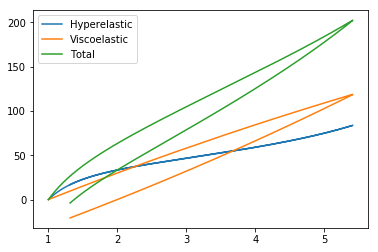

In [3]:
# Define test parameters
theta0 = {'Gc': 7.5541, 'Ge': 17.69, 'lam_max': 4.8333, 'eta': 708, 'gamma': 31}
theta0vec = list(theta0.values())

# Test hyperelastic model evaluation
n = 100
st = timetest()
for ii in range(n):
    sigma_inf = nonaffine_hyperelastic_model(theta0, stretch)
et = timetest()
print('NHM function average evaluation time: {} ms'.format((et - st)/n*1e3))

# Setup and test viscoelastic model evaluation
vislib = ctypes.cdll.LoadLibrary('./linear_viscoelastic_model.so')
linear_viscoelastic_model = vislib.linear_viscoelastic_model
linear_viscoelastic_model.restype = ndpointer(dtype = ctypes.c_double, shape=(nds,1))
linear_viscoelastic_model.argtypes = [ctypes.c_float, ctypes.c_float, ndpointer(ctypes.c_double), ndpointer(ctypes.c_double), ctypes.c_int]
n = 100
st = timetest()
for ii in range(n):
    q = linear_viscoelastic_model(theta0['eta'], theta0['gamma'], stretch, time, nds)
et = timetest()
print('LVM function average evaluation time: {} ms'.format((et - st)/n*1e3))

# Plot total stress
plt.plot(stretch, sigma_inf, label = 'Hyperelastic');
plt.plot(stretch, q, label = 'Viscoelastic');
plt.plot(stretch, sigma_inf + q, label = 'Total');
plt.legend();

### Setup MCMC Simulation
- Add data.
- Add model parameters.  Sample only viscoelastic parameters.
- Define model settings include sum-of-squares function - test evaluation.
- Define simulation options.

In [4]:
# Initialize MCMC object
mcstat = MCMC()
# Add data
mcstat.data.add_data_set(x = vhbdata['data']['xdata'][0][0], y = vhbdata['data']['ydata'][0][0])
# Define model parameters
mcstat.parameters.add_model_parameter(name = '$G_c$', theta0 = theta0['Gc'], minimum = 0, sample = False)
mcstat.parameters.add_model_parameter(name = '$G_e$', theta0 = theta0['Ge'], minimum = 0, sample = False)
mcstat.parameters.add_model_parameter(name = '$\lambda_{max}$', theta0 = theta0['lam_max'], minimum = 0, sample = False)
mcstat.parameters.add_model_parameter(name = '$\eta$', theta0 = theta0['eta'], minimum = 0, sample = True)
mcstat.parameters.add_model_parameter(name = '$\gamma$', theta0 = theta0['gamma'], minimum = 0, sample = True)
# Define sum-of-squares function and model settings
def ssfun(t, data):
    # Unpack data structure
    time = data.xdata[0][:,0]
    stretch = data.xdata[0][:,1]
    # Assign model parameters
    theta = {'Gc': t[0], 'Ge': t[1], 'lam_max': t[2], 'eta': t[3], 'gamma': t[4]}
    # Evaluate model
    stress_model = nonaffine_hyperelastic_model(theta, stretch) + linear_viscoelastic_model(theta['eta'], theta['gamma'], stretch, time, data.n[0])
    # Calculate sum-of-squares error
    res = data.ydata[0] - stress_model
    ss = np.dot(res.T, res)
    return ss

n = 100
st = timetest()
for ii in range(n):
    sstest = ssfun(theta0vec, mcstat.data)
et = timetest()
print('SOS function evaluation time: {} ms'.format((et - st)/n*1e3))
mcstat.model_settings.define_model_settings(sos_function = ssfun)

# Define simulation options
mcstat.simulation_options.define_simulation_options(nsimu = int(5.0e3), updatesigma = True)

SOS function evaluation time: 0.4589509963989258 ms


### Run Simulation
Take first part of chain as the burnin period.  Display statistics and plots based on latter portion of chain.


Sampling these parameters:
      name      start [      min,       max] N(       mu,   sigma^2)
    $\eta$:    708.00 [ 0.00e+00,       inf] N( 0.00e+00,      inf)
  $\gamma$:     31.00 [ 0.00e+00,       inf] N( 0.00e+00,      inf)


/Users/prmiles/anaconda3/envs/pypi_pymcmcstat/lib/python3.6/site-packages/pymcmcstat/samplers/Metropolis.py:125: RuntimeWarning: overflow encountered in exp
  alpha = np.exp(-0.5*(sum((ss1 - ss2)*(sigma2**(-1))) + newprior - oldprior))


 [-----------------100%-----------------] 5000 of 5000 complete in 2.2 sec
---------------------
name      :       mean        std     MC_err        tau     geweke
$\eta$    :   736.5183    12.1444     0.6910     6.3384     0.9980
$\gamma$  :    33.3648     0.1704     0.0075     5.7383     0.9985
---------------------


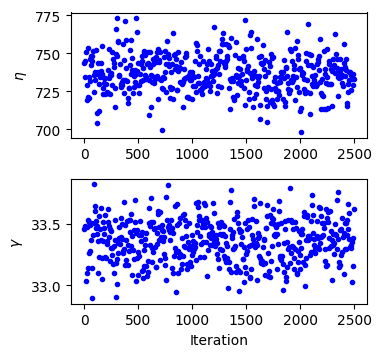

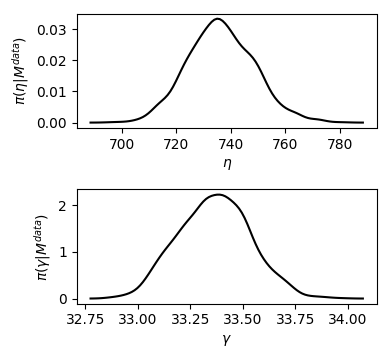

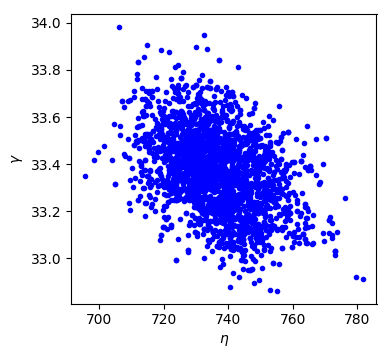

In [5]:
# Run Simulation
mcstat.run_simulation()

results = mcstat.simulation_results.results
names = results['names']
fullchain = results['chain']
fulls2chain = results['s2chain']
nsimu = results['nsimu']
burnin = int(nsimu/2)
chain = fullchain[burnin:,:]
s2chain = fulls2chain[burnin:,:]

mcstat.chainstats(chain, results)

# plot chain metrics
mcstat.mcmcplot.plot_chain_panel(chain, names, figsizeinches=(4,4));
mcstat.mcmcplot.plot_density_panel(chain, names, figsizeinches=(4,4));
mcstat.mcmcplot.plot_pairwise_correlation_panel(chain, names, figsizeinches=(4,4));

## Plotting Prediction/Credible Intervals
We can display the prediction/credible intervals in several different ways.
1. Plot intervals with respect to time.
2. Plot intervals with respect to stretch.

In either case, we can use the same function to generate the intervals.

In [8]:
def predmodelfun(data, t):
    xdata = data.user_defined_object[0]
    theta = {'Gc': t[0], 'Ge': t[1], 'lam_max': t[2], 'eta': t[3], 'gamma': t[4]}
    stress = nonaffine_hyperelastic_model(theta, xdata[:,1]) + linear_viscoelastic_model(theta['eta'], theta['gamma'], xdata[:,1], xdata[:,0], data.n[0])
    return stress

### 1. Plot Intervals With Respect to Time
This approach is fairly straight-forward.  We define a new data structure and define the `x` variable as `time`.  As the model evaluation requires both `stretch` and `time`, we include that information in the `user_define_object` variable.

Generating credible/prediction intervals:


Interval generation complete



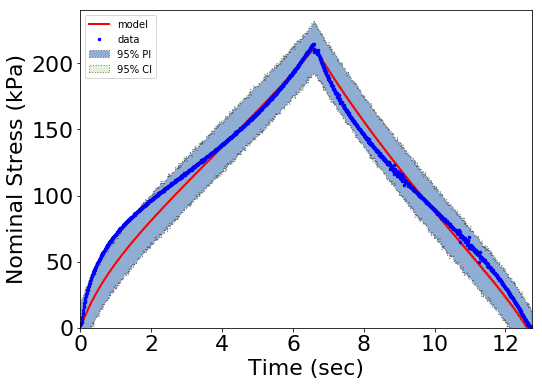

In [9]:
# plot wrt time
pdata = DataStructure()
pdata.add_data_set(x = time, y = stress, user_defined_object = vhbdata['data']['xdata'][0][0])
mcstat.PI.setup_prediction_interval_calculation(results = results, data = pdata, modelfunction = predmodelfun, burnin = burnin)
mcstat.PI.generate_prediction_intervals(nsample = 500, calc_pred_int = True)
# plot prediction intervals
mcstat.PI.plot_prediction_intervals(adddata = True);
plt.xlabel('Time (sec)', fontsize = 22)
plt.xticks(fontsize = 22)
plt.ylabel('Nominal Stress (kPa)', fontsize = 22)
plt.yticks(fontsize = 22)
plt.xlim([0,time[-1]])
plt.ylim([0,240])
plt.savefig('viscoelasticity_pi.png', format = 'png', dpi = 500, bbox_inches='tight')

### 2. Plot Intervals With Respect to Stretch
This approach is made much more complicated due to a an interesting feature of the `fill_between` method in the `matplotlib` libary.  The behavior is the same as what you observe when using the MATLAB command `fill`.  If in the same call to the filling function the same area is filled more than once, the filling is actually undone.  To account for this we must break the plotting portion into two distinct sections: loading and unloading.  The interval generation is still the same however, and is accomplished by defining a new data structure with the `x` variable equal to `stretch`.

In [10]:
pdata = DataStructure()
pdata.add_data_set(x = stretch, y = stress, user_defined_object = vhbdata['data']['xdata'][0][0])
mcstat.PI.setup_prediction_interval_calculation(results = results, data = pdata, modelfunction = predmodelfun, burnin = burnin)
mcstat.PI.generate_prediction_intervals(nsample = 500, calc_pred_int = True)

Generating credible/prediction intervals:


Interval generation complete



To resolve the issue with plotting, we must extract the generated intervals and break them into two sections: 
1. Loading
2. Unloading.

In [11]:
intervals = mcstat.PI.intervals
# find maximum stretch - corresponds to transition between loading and unloading
sid = np.argmax(stretch)
# 1. Loading
intervals_1 = {'credible_intervals': [[intervals['credible_intervals'][0][0][:,0:sid]]],
               'prediction_intervals': [[intervals['prediction_intervals'][0][0][:,0:sid]]]}
stretch_1 = stretch[0:sid]
stress_1 = stress[0:sid].reshape(stress[0:sid].size,1)
# 2. Unloading
intervals_2 = {'credible_intervals': [[intervals['credible_intervals'][0][0][:,sid:]]],
               'prediction_intervals': [[intervals['prediction_intervals'][0][0][:,sid:]]]}
stretch_2 = stretch[sid:]
stress_2 = stress[sid:].reshape(stress[sid:].size,1)

Finally, we can call the plotting routine twice with the intervals defined for loading and unloading, respectively.  It is noted that this ability to merge results from two separate calls to the plotting routine may not work indefinitely.  Future releases of `pymcmcstat` will aim to provide a cleaner method for combining intervals from multiple calls to the plotting routine.

/Users/prmiles/anaconda3/envs/pypi_pymcmcstat/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


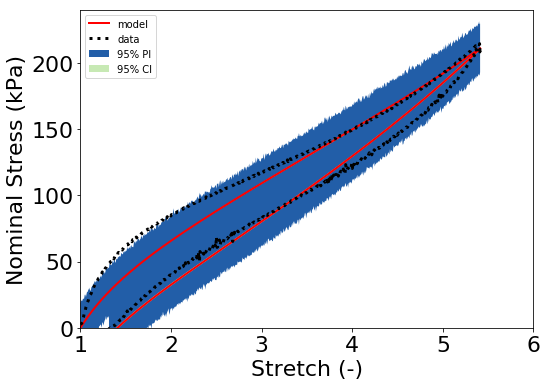

In [12]:
# plot 1st interval
interval_display = {'alpha': 1.0, 'edgecolor': 'none'}
data_display = {'color': 'k', 'linestyle': ':', 'marker': '', 'linewidth': 3}
mcstat.PI.intervals = intervals_1.copy()
mcstat.PI.datapred[0].xdata[0] = stretch_1
mcstat.PI.datapred[0].ydata[0] = stress_1
fighandle, axhandle = mcstat.PI.plot_prediction_intervals(adddata = True, addlegend = False, data_display = data_display, interval_display = interval_display);
leghand, leglab = axhandle[0].get_legend_handles_labels()
# plot 2nd interval
mcstat.PI.intervals = intervals_2.copy()
mcstat.PI.datapred[0].xdata[0] = stretch_2
mcstat.PI.datapred[0].ydata[0] = stress_2
mcstat.PI.plot_prediction_intervals(adddata = True, addlegend = False, data_display = data_display, interval_display = interval_display);

plt.xlabel('Stretch (-)', fontsize = 22);
plt.xticks(fontsize = 22);
plt.ylabel('Nominal Stress (kPa)', fontsize = 22);
plt.yticks(fontsize = 22)
plt.xlim([1,6]);
plt.ylim([0,240]);
plt.legend(handles = leghand, labels = leglab);